In [1]:
import os
from typing import Optional

from notebook_utils import * 

# 1. Python in 10 minutes

This interface allows you to run Python code interactively and view the results immediately, along with any visualizations or text explanations. Each block of code or text you see is contained in what we call a "cell."

## Basic Operations

- **Running a Cell**: You can run the code or render the markdown in a cell by selecting it and pressing `Shift + Enter`, or by clicking the "Run" button in the toolbar.
- **Adding New Cells**: Add a new cell by clicking the "+" button in the toolbar.
- **Cell Types**: Cells can be code cells or markdown cells. Switch the type using the dropdown in the toolbar.


In [2]:
# Simple Python Example

# Printing a message
print("Hello, World!")

# Basic arithmetic
result = 7 * 6
print("7 multiplied by 6 is", result)

Hello, World!
7 multiplied by 6 is 42


In [3]:
# Using Variables

# Store a value in a variable
a = 10

# Use the variable in a calculation
b = a * 2

# Print the result
print("The result of a multiplied by 2 is", b)

The result of a multiplied by 2 is 20


In [4]:
# Basic Data Structures

# List: an ordered collection of items
fruits = ["apple", "banana", "cherry"]
print("Fruits List:", fruits)

# Dictionary: key-value pairs
prices = {"apple": 0.40, "banana": 0.50, "cherry": 0.30}
print("Fruit Prices:", prices)

Fruits List: ['apple', 'banana', 'cherry']
Fruit Prices: {'apple': 0.4, 'banana': 0.5, 'cherry': 0.3}


In [5]:
# Looping through a list
for fruit in fruits:
    print(fruit, "costs", prices[fruit], "each")

# Conditional: if statement
if "banana" in fruits:
    print("Yes, we have bananas!")

apple costs 0.4 each
banana costs 0.5 each
cherry costs 0.3 each
Yes, we have bananas!


### Introduction to Functions

Functions are a way to organize your code into blocks that can be called multiple times throughout your program. They allow you to write cleaner, more modular code and make your scripts easier to maintain and debug. Functions in Python are defined using the `def` keyword.


In [6]:
# Defining a Simple Function


def greet(name):
    """This function greets the person whose name is passed as a parameter"""
    return f"Hello, {name}! Welcome to our notebook."


# Calling the function
greeting = greet("Alice")
print(greeting)

Hello, Alice! Welcome to our notebook.


In [7]:
# Function with Parameters and Return Value


def calculate_area(length, width):
    """This function returns the area of a rectangle given its length and width."""
    area = length * width
    return area


# Using the function
rect_area = calculate_area(10, 5)
print("The area of the rectangle is:", rect_area)

The area of the rectangle is: 50


### Leveraging Jupyter-AI for Code Generation

Jupyter-AI is an advanced feature integrated into Jupyter Notebooks that helps users write code more efficiently. It utilizes AI technology to suggest code snippets, complete code blocks, and even generate complex code structures.

#### How to Use Jupyter-AI to Write Code

1. **Initiating Code Suggestions**: Simply start typing your code or a description of the function you need in a code cell. Jupyter-AI will automatically suggest completions.
2. **Accepting Suggestions**: When a code suggestion appears, you can press `Tab` to accept it, instantly filling in the suggestion.
3. **Chat Interface**: You can also interact with Jupyter-AI using the chat interface on the left.


In [ ]:
# try using the autocomplete functioanlity to write a function that adds two numbers


def add_numbers(a: int, b: int) -> int:
    """Try having jupyter AI autocomplete this function."""
    pass


# Assert statements to check the correctness of the function
assert add_numbers(1, 2) == 3, "Function add_numbers does not work correctly!"
print("Function add_numbers works correctly!")

In [ ]:
# We're not limited to simple functions. Here's a tricky function with a bug in it. Try pasting it into the chat bar on the left and asking the AI to fix it


def factorial(n: int) -> int:
    """This function has a bug in it. Can you find and fix it with AI?"""
    if n == 0:
        return 1
    else:
        result = 1
        for i in range(n):
            result *= i
        return result


# Assert statements to check the correctness of the function
assert factorial(0) == 1, "The factorial of 0 should be 1"
assert factorial(1) == 1, "The factorial of 1 should be 1"
assert factorial(5) == 120, "The factorial of 5 should be 120"

### Let's get started with the case study!


# High Level Architecture

The architecture of the system is as follows:

1. We chunk up the document into distinct “sections” and embed those sections
2. Then, we embed the user query and find the most similar part of the document.
3. We feed the original question along with context we found to the LLM and receive an answer


# 2. What exactly is an embedding?


In [7]:
from openai import OpenAI, NOT_GIVEN
import instructor
import plotly.graph_objects as go

#########################
### UTILITY FUNCTIONS ###
#########################

# instantiating the OpenAI client
client = instructor.patch(OpenAI(api_key=os.getenv("OPEN_AI_KEY")))
batch_size = 250
embedding_model = "text-embedding-3-large"


# wrapper function around openai to directly return embedding of text
def get_embedding(text: str | list[str], dimensions: int = NOT_GIVEN) -> list[float]:
    """Get the embedding of the input text."""
    if dimensions:
        assert dimensions <= 3072, "The maximum number of dimensions is 3072."

    response = client.embeddings.create(
        input=text, model=embedding_model, dimensions=dimensions
    )
    return response.data[0].embedding


def get_many_embeddings(texts: list[str]) -> list[list[float]]:
    """Get the embeddings of multiple texts."""
    batch_size = 250
    res = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        api_resp = client.embeddings.create(input=batch_texts, model=embedding_model)
        batch_res = [val.embedding for val in api_resp.data]
        res.extend(batch_res)

    return res


# simple utility function to add a vector to a 3D plot
def add_vector_to_graph(
    fig: go.Figure, vector: list[float], color: str = "red", name: Optional[str] = None
) -> go.Figure:
    # Ensure vector has exactly three components
    assert len(vector) == 3, "Vector must have exactly 3 components."

    # Origin point
    origin = [0, 0, 0]

    # Components of the vector
    x_component, y_component, z_component = vector

    # Adding the line part of the vector
    fig.add_trace(
        go.Scatter3d(
            x=[origin[0], x_component],
            y=[origin[1], y_component],
            z=[origin[2], z_component],
            mode="lines",
            line=dict(color=color, width=5),
            name=name,
        )
    )

    # Adding the cone at the tip of the vector
    fig.add_trace(
        go.Cone(
            x=[x_component],
            y=[y_component],
            z=[z_component],
            u=[x_component],
            v=[y_component],
            w=[z_component],
            sizemode="scaled",
            sizeref=0.1,
            showscale=False,
            colorscale=[[0, color], [1, color]],
            hoverinfo="none",
        )
    )
    return fig


def create_new_graph() -> go.Figure:
    """Create a 3D plotly figure with a simple layout."""
    fig = go.Figure()

    # make sure the plot isn't rotated
    fig.update_layout(
        scene=dict(
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=0.5),  # Adjust the camera position
                up=dict(x=0, y=0, z=1),  # Sets the z-axis as "up"
                center=dict(x=0, y=0, z=0),  # Focuses the camera on the origin
            ),
            aspectmode="cube",
        )
    )

    # Add a dot at the origin
    fig.add_trace(
        go.Scatter3d(
            x=[0],
            y=[0],
            z=[0],
            mode="markers",
            marker=dict(size=6, color="black", symbol="circle"),
            name="Origin",
        )
    )

    return fig

#### Let's get started

For the purpose of the notebook we're going to use an OpenAI approach.

In [9]:
# let's try using the get_embedding function
result = get_embedding("Hello, World!")
print(result)

[0.0041542695835232735, -0.020751770585775375, -0.01990603841841221, 0.03354739025235176, 0.0029346137307584286, -0.01956148073077202, 0.0022180902305990458, 0.045011766254901886, 0.03433047607541084, 0.034769006073474884, -0.011840255931019783, 0.02700079418718815, 0.004694598726928234, -0.013218486681580544, 0.0020321074407547712, 0.03160533681511879, -0.04285044968128204, 0.01204385794699192, -0.0012558737071231008, -0.020892726257443428, 0.03721223026514053, -0.002409946173429489, -0.047110434621572495, 0.009819895029067993, 0.0006347888265736401, 0.020830079913139343, 0.008903684094548225, -0.0021045426838099957, -0.01970243640244007, -0.038809727877378464, 0.004060299135744572, 0.004573220387101173, 0.013116685673594475, 0.04670323058962822, 0.0506499819457531, 0.004949101712554693, 0.011339080519974232, 0.02253720536828041, 0.01425999030470848, 0.014839474111795425, 0.0168989896774292, 0.037525467574596405, -0.0023825382813811302, 0.03213783726096153, 0.010642134584486485, -0.00

That's a lot of numbers! OpenAI embedding support built in dimensionality reduction - let's try using that and visualizing the result


In [10]:
graph = create_new_graph()

text = "Atlanta"

# Get the embedding of the text
vector = get_embedding(text, dimensions=3)

# Add the vector to the plot
add_vector_to_graph(graph, vector, name=text)

# Show the plot
graph.show()

Let's try plotting a couple vectors at once to see if we can see any patterns

In [11]:
graph = create_new_graph()

text = "Atlanta"
atlanta_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, atlanta_vector, name=text, color="purple")

text = "Georgia, USA"
georgia_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, georgia_vector, name=text, color="blue")

text = "Skiing in japan"
ski_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, ski_vector, name=text, color="red")

# Show the plot
graph.show()

How we can quantify the similarity between two vectors? One common way is to use the cosine similarity. The cosine similarity between two vectors is the cosine of the angle between them. It ranges from -1 (opposite directions) to 1 (same direction), with 0 indicating orthogonality.

In [8]:
import numpy as np


def cosine_similarity(a: list[float], b: list[float]) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# We can use the cosine similarity to compare the similarity between two vectors
similarity = cosine_similarity(atlanta_vector, georgia_vector)
print(f"The similarity between 'Atlanta' and 'Georgia, USA' is {similarity:.2f}")

similarity = cosine_similarity(atlanta_vector, ski_vector)
print(f"The similarity between 'Atlanta' and 'Skiing in Japan' is {similarity:.2f}")

NameError: name 'atlanta_vector' is not defined

### Advanced Challenges (Optional)

#### 1. Sentence Embeddings

How does adding words to a sentence affect the embedding vector? Try creating a for loop that adds a word to the text and plots the resulting embedding vector.

#### Hints:
1. Python strings have a split() method

```py
text = "This is a sentence."
words = text.split()
>>> words
['This', 'is', 'a', 'sentence.']
```


#### 2. Embedding Dimensionality
Let's see how the cosine similarity changes as we change the number of dimensions. 

How does increasing the number of dimensions affect how well the model can capture relationships between complex concepts?

In [56]:
# Try it out (implemented solutions can be found in the solutions.ipynb notebook)


# 3. Parsing Documents

Large language models are currently primarly optimized for working with text. As a result when dealing with documents like PDF's we need to first convert them into a text format before we can feed them into the model.

We maintain a popular open source library for doing this called [openparse](https://github.com/Filimoa/open-parse/). It is a simple and easy to use.


In [29]:
import openparse

#########################
### UTILITY FUNCTIONS ###
#########################


class VectorDatabase:
    """
    A simple in-memory database to store nodes along with their vectors and perform similarity search.
    """

    def __init__(self):
        self.nodes = []

    def add_node(self, node: openparse.Node) -> None:
        """Add a node along with its vector to the database."""
        assert node.embedding is not None, "Node must have an embedding."

        for existing_node in self.nodes:
            if existing_node.text == node.text:
                print(f"Node with id {node.node_id} already exists. Skipping")
                return

        self.nodes.append(node)

    def find_node(self, node_id: str):
        """Retrieve a node by its ID."""
        for node in self.nodes:
            if node.node_id == node_id:
                return node
        return None

    def remove_node(self, node_id: int) -> None:
        """Remove a node from the database."""
        for node in self.nodes:
            if node.node_id == node_id:
                self.nodes.remove(node)
                return
        raise ValueError(f"Node with id {node_id} not found.")

    def find_similar_node(
        self, input_vector: list[float], top_k: int = 3
    ) -> list[openparse.Node]:
        """Find the top_k nodes with the highest cosine similarity to the input_vector."""
        assert self.nodes, "Database is empty. Please add nodes first."
        assert top_k <= len(
            self.nodes
        ), "top_k should be less than or equal to the number of nodes."

        similarities = []
        for node in self.nodes:
            similarity = cosine_similarity(input_vector, node.embedding)
            similarities.append((node, similarity))

        similarities.sort(key=lambda x: x[1], reverse=True)

        return [node for node, _ in similarities[:top_k]]

    @property
    def num_nodes(self) -> int:
        """Return the number of nodes in the database."""
        return len(self.nodes)

    def delete_all_nodes(self) -> None:
        """Delete all nodes from the database."""
        self.nodes = []


# try:
#     assert db
# except NameError:
#     db = VectorDatabase()

db = VectorDatabase()

In [30]:
import openparse

doc_path = "./docs/portland-site-assessment-phase-1.pdf"
pdf = openparse.Pdf(doc_path)
parser = openparse.DocumentParser()
parsed_doc = parser.parse(doc_path)

Nodes are parsed as markdown - bold text is kept. This helps LLM's understand the structure of the document. Let's try looking at the first couple nodes.

In [32]:
for node in parsed_doc.nodes[10:11]:
    display(node)
    print("====================================")

RECOGNIZED ENVIRONMENTAL CONDITIONS <br><br>ASTM E1527-13 defines RECs as the presence or likely presence of any hazardous substances or 
petroleum products in, on, or at a property: (1) due to any release to the environment; (2) under 
conditions indicative of a release to the environment; or (3) under conditions that pose a material 
threat of a future release to the environment. <br><br>No uncontrolled RECs were identified for the Property. <br><br>CONTROLLED RECOGNIZED ENVIRONMENTAL CONDITIONS <br><br>ASTM E1527-13 defines controlled RECs (CRECs) as resulting from a past release of hazardous 
substances or petroleum products that has been addressed to the satisfaction of the applicable 
regulatory authority. <br><br>The CRECs identified through completion of this Phase I ESA are noted below and are discussed in 
further detail throughout this report. Figure ES-1 displays the area names used to describe different 
portions of the Property. <br><br>• Groundwater concentration in excess of the DEQ residential, urban residential, and 
occupational risk-based concentrations (RBCs) for lead, arsenic, polycyclic aromatic 
hydrocarbons (PAHs), diesel-range organics (DRO), and residual-range organics (RRO) 
have been observed on portions of the Property. In addition, benzo(a)pyrene (a PAH) 
was observed in groundwater in excess of the DEQ excavation worker RBC in two 
locations on the southeastern portion of the Property (one in Riverside and one in the 
Barker Area). <br><br>• PAHs in shallow soil above the DEQ residential, urban residential, and occupational <br><br>RBCs in the Lumber Mill Area. 

In [33]:
# let's embed all the nodes and add to the database
raw_node_texts = [node.text for node in parsed_doc.nodes]
embeddings = get_many_embeddings(raw_node_texts)

for node, embedding in zip(parsed_doc.nodes, embeddings):
    node.embedding = embedding
    db.add_node(node)

Node with id 0f511e9c-ec2d-414f-96ff-3a67c27bf6a7 already exists. Skipping


# 4. Querying

In [34]:
#########################
### UTILITY FUNCTIONS ###
#########################

from IPython.display import Markdown


def get_completion(prompt: str) -> Markdown:
    """
    OpenAI returns a complex object, this is a simple wrapper function to directly return the completion text.
    """
    completion = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )
    return Markdown(completion.choices[0].message.content)


def display_similar_nodes(
    similar_nodes: list[openparse.Node], query_vector: list[float], pdf: openparse.Pdf
) -> None:
    page_nums = set()
    annotations = []
    for node in similar_nodes:
        sim = cosine_similarity(query_vector, node.embedding)
        page_nums.add(node.start_page)
        page_nums.add(node.end_page)
        annotations.append(round(sim, 3))

    pdf.display_with_bboxes(similar_nodes, page_nums=page_nums, annotations=annotations)

In [41]:
# let's try asking one of our original questions

question = "Is there lead contamination into the groundwater?"

# Get the embedding of the text
query_vector = get_embedding(question)

# find the most similar node
similar_nodes = db.find_similar_node(query_vector, top_k=5)

for node in similar_nodes:
    sim = cosine_similarity(query_vector, node.embedding)
    print(
        f"Found similar node on page {node.start_page} with a similarity of {sim:.2f}"
    )

Found similar node on page 26 with a similarity of 0.59
Found similar node on page 31 with a similarity of 0.54
Found similar node on page 28 with a similarity of 0.53
Found similar node on page 24 with a similarity of 0.53
Found similar node on page 28 with a similarity of 0.50


You can give GPT knowledge about a topic by inserting it into an input message
To help give the model knowledge of curling at the 2022 Winter Olympics, we can copy and paste the top half of a relevant Wikipedia article into our message:

In [42]:
# create a single string of all the similar nodes
context = "\n\n".join([node.text for node in similar_nodes])

print(context)

• Lead—residential, urban residential, and occupational RBC exceedances in groundwater, 
in three of four locations assessed in the Lathe Area. The only other area assessed for 
lead in groundwater was Riverside; lead was not detected above RBCs in these samples. <br><br>• PAHs (multiple)—residential, urban residential, and occupational RBC exceedances in 
groundwater were observed in the following assessed areas: the Lathe Area, the Oil 
House and Transformer Area, the Barker Area, Riverside, and the Maintenance Shop 
and UST Area. PAHs were not observed in samples collected from the Sorter/Stacker 
Area. Benzo(a)pyrene was observed to exceed the DEQ excavation worker RBC in two 
locations, one in the Riverside Area and one in the Barker Area. <br><br>• DRO/RRO—residential, urban residential, and occupational RBC exceedances in 
groundwater were observed in the following assessed areas: the Lathe Area, the Oil 
House and Transformer Area, the Barker Area, and Riverside. Residential an

In [43]:
prompt_template = """
Using the document provided, answer the following question:

question: {question}

context: {context}
"""

prompt = prompt_template.format(question=question, context=context)

completion = get_completion(prompt)


print("Original Question:", question)
completion

Original Question: Is there lead contamination into the groundwater?


Yes, there is lead contamination in the groundwater. The context mentions that lead residential, urban residential, and occupational RBC exceedances in groundwater were found in three of the four locations assessed in the Lathe Area.

### We can display citations showing users exactly where we got our answer

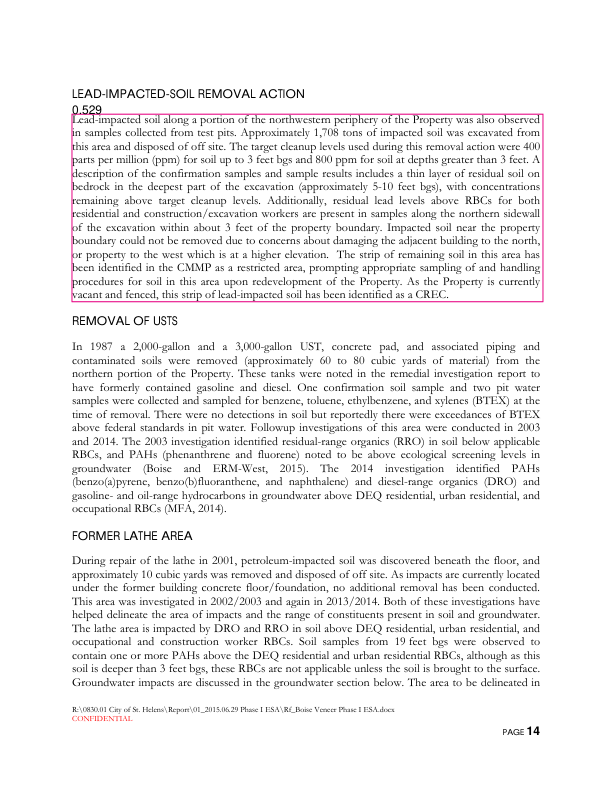

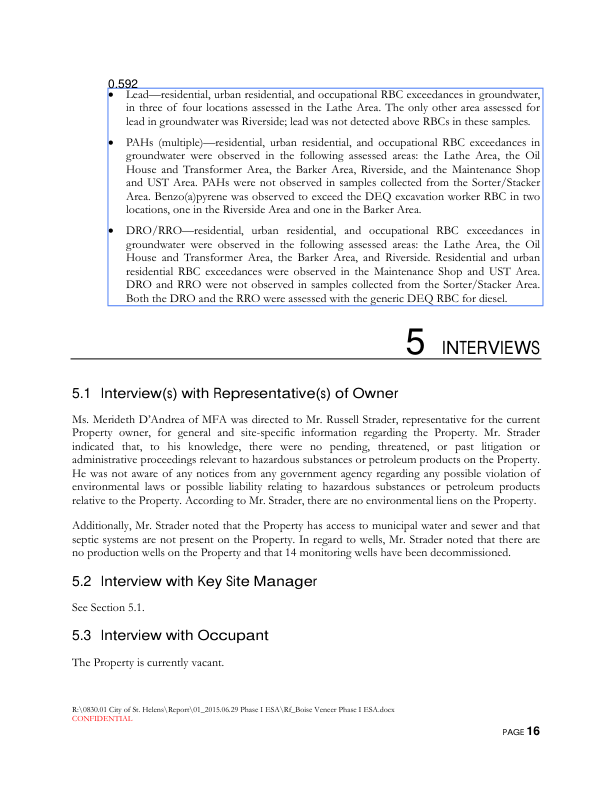

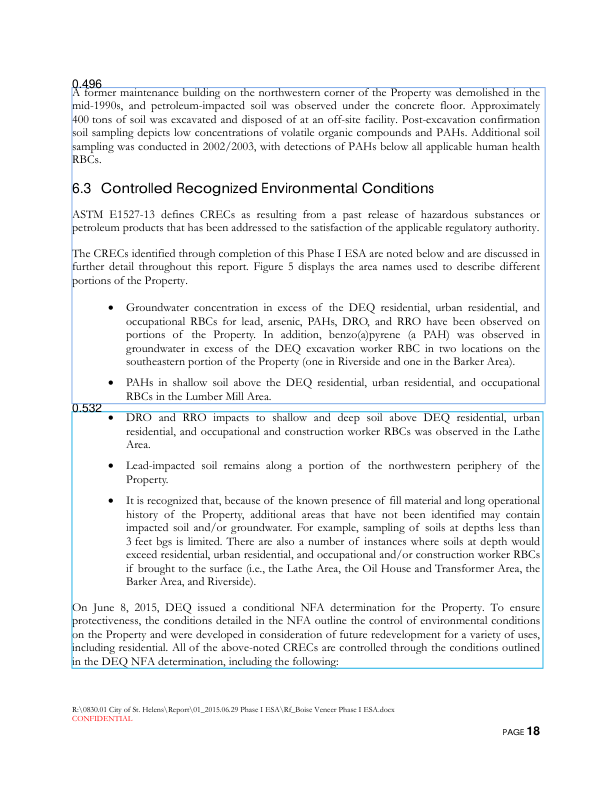

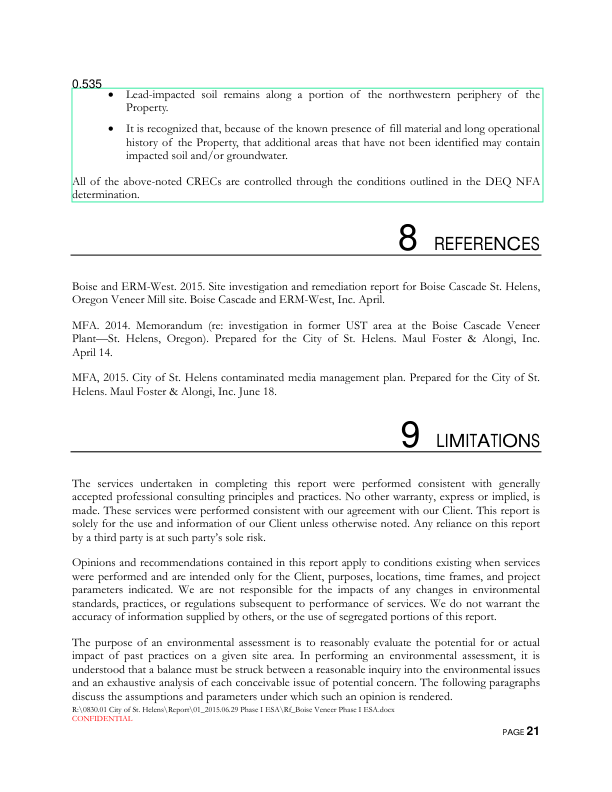

In [44]:
display_similar_nodes(similar_nodes, query_vector, pdf)

### Advanced Challenges (Optional)

#### 1. Modifying Embedding Dimensions

Try modifying the number of dimensions in the embedding vector and seeing how it affects the retrieval process.  You will need to clear the database and reembed the nodes. You can do that with `db.delete_all_nodes()`.

## 5: Structured Output

In [45]:
from pydantic import BaseModel


class ContainsHazards(BaseModel):
    contains_lead: bool


response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
        {
            "role": "user",
            "content": prompt,
        },
    ],
    response_model=ContainsHazards,
)

print(response.dict())

{'contains_lead': True}


In [47]:
if response.contains_lead:
    question = "What mitigations have been performed up to this point to deal with the lead exposure?"

    query_vector = get_embedding(question)

    similar_nodes = db.find_similar_node(query_vector, top_k=5)

    context = "\n\n".join([node.text for node in similar_nodes])

    prompt = prompt_template.format(question=question, context=context)

    mitigations_performed = get_completion(prompt)


In [51]:
mitigations_performed

To address the lead exposure, the following mitigation actions have been performed:

1. **Excavation and Off-site Disposal:** Approximately 1,708 tons of lead-impacted soil were excavated along the northwestern periphery of the property, with the soil being removed and disposed of at an off-site location. This action primarily aimed to contain and eliminate direct exposure to the contaminated soil.

2. **Targeted Cleanup Levels:** The project enforced specific cleanup levels of 400 parts per million (ppm) for soil up to 3 feet below ground surface (bgs) and 800 ppm for soil at depths greater than 3 feet bgs during the removal action. This standard was used to ensure the reduction of lead to safer levels.

3. **Confirmation Sampling and Results Analysis:** After excavation, confirmation samples were taken mostly near the bedrock in the deepest part of the excavation (5-10 feet bgs). This helped to assess the residual soil's lead concentrations. Although some lead levels remained above the target cleanup, this step was crucial for ongoing monitoring and assessment.

4. **Management of Non-Removable Impacted Soil:** For impacted soil near the property boundary that could not be removed to avoid damage to adjacent properties, a specific area has been designated as a restricted area within the provided Controlled Recognizable Environmental Condition (CREC) strategy. This designation requires specific handling and sampling procedures before any redevelopment work in these areas.

5. **Fencing and Property Vacancy:** The currently vacant property has been fenced. This precautionary measure serves to prevent unauthorized access that could lead to direct exposure to contaminated soil.

6. **DEQ No Further Action (NFA) Conditional Determination:** Issued on June 8, 2015, this determination involves specific conditions to control environmental conditions, such as the CRECs. It outlines regulations and measures that must be adhered to in consideration of various potential future uses of the property, including residential uses. 

Overall, these actions work collaboratively to mitigate the risks from historical lead contamination and monitor any potential future impacts as the site awaits redevelopment.

In [55]:
question = (
    "Why were the following mitigations to remove the lead from the property ineffective "
    + mitigations_performed.data
)

query_vector = get_embedding(question)

# this is a more complex question, let's expand the search to top 9 nodes
similar_nodes = db.find_similar_node(query_vector, top_k=9)

context = "\n\n".join([node.text for node in similar_nodes])

prompt = prompt_template.format(question=question, context=context)

failure_reasons = get_completion(prompt)

In [56]:
failure_reasons

The mitigations to remove lead from the property were ineffective for several reasons:

1. **Incomplete Excavation:**
   The excavation only addressed lead-impacted soil along the northwestern periphery of the property. It did not extend to other potentially contaminated areas. This selective excavation left residual lead contamination in other parts, as hinted by remaining high concentrations of lead in confirmation samples near the bedrock and along the northern sidewall of the excavation close to the property boundary.

2. **Inadequate Depth and Scope of Excavation:**
   Confirmation sampling after the excavation revealed lead concentrations remaining above target cleanup levels, especially in deeper layers (5-10 feet bgs) and near structures where excavation could threaten the integrity of neighboring properties or structures. The exposure of deeper soils containing higher lead concentrations than the target cleanup levels indicates that the excavation might not have reached all the contaminated areas.

3. **Property Boundary Constraints:**
   Lead-impacted soil near the property boundary could not be entirely removed due to the risk of damaging adjacent properties. This constraint limited the effectiveness of soil removal as a mitigation strategy since some contaminated soil was left in situ.

4. **Limited Sampling and Assessment Coverage:**
   The document suggests that sampling of soils at depths less than 3 feet bgs was limited. Moreover, the areas requiring stringent cleanup due to historical and operational uses of the property (e.g., the Lathe Area, Oil House and Transformer Area) might contain soil and groundwater exceeding safe residential and occupational standards if disturbed. This limitation in sampling indicates that not all potential lead contamination areas were adequately assessed or addressed.

5. **Restrictions on Certain Mitigation Actions:**
   Certain critical areas with residual contamination, such as the northern removal area and areas around specific test pits, require specific handling procedures outlined in the DEQ-approved contaminated-media management plan (CMMP). These restrictions and potential bureaucratic delays could have slowed down or limited more aggressive remediation actions.

Overall, the ineffectiveness of the mitigation efforts appears tied to a combination of incomplete excavation, constraints due to property boundaries, limits in the depth and scope of excavation, and perhaps oversight or lack of coverage in the initial assessments and ongoing monitoring needed to fully understand and manage the site contamination. The conditional nature of the DEQ No Further Action (NFA) determination also suggests ongoing management rather than full remediation of the lead contamination.